Simulation Parameters:

1. Calculate daily range
2. Set a lower threshold
3. Long entries are when the price closes in the bottom n% of the day's range, defined by the threshold
4. Measure how often this is followed by an upwards move
5. Run the simulation with various thresholds and graph

In [1]:
#import libraries
import yfinance as yf
import datetime
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#define variables
SYMBOL = "^GSPC"
PCT_THRESH = 20

In [3]:
#define date range
START = datetime.datetime(2000, 1, 1)
END = datetime.datetime(2020, 1, 1)
YEARS = (END - START).days / 365.25

In [4]:
#download data
price = yf.download(SYMBOL, start=START, end=END)

price.tail()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,3223.379883,1296530000
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,3239.909912,2164540000
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,3240.020020,2429150000
2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039,3221.290039,3021720000
2019-12-31,3215.179932,3231.719971,3212.030029,3230.780029,3230.780029,2894760000


In [5]:
#drop redundant columns
price = price.drop(['Volume', 'Adj Close'], axis=1)

price.tail()

,Open,High,Low,Close
Date,,,,
2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020
2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039
2019-12-31,3215.179932,3231.719971,3212.030029,3230.780029


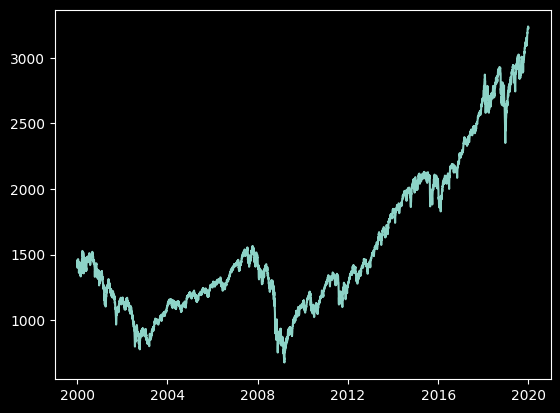

In [6]:
plt.style.use('dark_background')
plt.plot(price.Close)

plt.show()

In [7]:
#calculate benchmark return
price['Return'] = price.Close / price.Close.shift(1)
price.Return.iat[0] = 1

#calculate daily range
price['Range'] = price.High - price.Low

#calculate distance from close to low
price['Dist'] = abs(price.Close - price.Low)

#distance as % of range
price['Pct'] = (price.Dist / price.Range) * 100

price.tail()

,Open,High,Low,Close,Return,Range,Dist,Pct
Date,,,,,,,,
2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,0.999805,5.919922,2.869873,48.478225
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,1.005128,12.880127,12.709961,98.678848
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,1.000034,13.559814,5.649902,41.666517
2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039,0.994219,24.349854,4.719971,19.383980
2019-12-31,3215.179932,3231.719971,3212.030029,3230.780029,1.002946,19.689941,18.750000,95.226286


In [8]:
#entry triggers
price['Long'] = price.Pct < PCT_THRESH

#system return
price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1.0)

price.tail()

,Open,High,Low,Close,Return,Range,Dist,Pct,Long,Sys_Ret
Date,,,,,,,,,,
2019-12-24,3225.449951,3226.429932,3220.510010,3223.379883,0.999805,5.919922,2.869873,48.478225,False,1.000000
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,1.005128,12.880127,12.709961,98.678848,False,1.000000
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,1.000034,13.559814,5.649902,41.666517,False,1.000000
2019-12-30,3240.090088,3240.919922,3216.570068,3221.290039,0.994219,24.349854,4.719971,19.383980,True,1.000000
2019-12-31,3215.179932,3231.719971,3212.030029,3230.780029,1.002946,19.689941,18.750000,95.226286,False,1.002946


In [9]:
#benchmark up and down days
bench_win = price.Return[price.Return > 1.0].count()
bench_loss = price.Return[price.Return < 1.0].count()
bench_winrate = round((bench_win / (bench_win + bench_loss)) * 100, 2)

#extract the up and down days
sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

print(f'Benchmark Winrate: {bench_winrate}%')
print('')
print(f'Trades Won: {sys_win}')
print(f'Trades Loss: {sys_loss}')
print(f'System Winrate: {sys_winrate}%')

Benchmark Winrate: 53.57%

Trades Won: 622
Trades Loss: 437
System Winrate: 58.73%


In [10]:
def simulate(price, threshold):
    
    #entry triggers
    price['Long'] = price.Pct < threshold

    #system return
    price['Sys_Ret'] = np.where(price.Long.shift(1) == True, price.Return, 1.0)
    
    #extract the up and down days
    sys_win = price.Sys_Ret[price.Sys_Ret > 1.0].count()
    sys_loss = price.Sys_Ret[price.Sys_Ret < 1.0].count()
    sys_winrate = round(sys_win / (sys_win + sys_loss) * 100, 2)

    return sys_winrate

In [14]:
#blank list for backtest results
results = []
pct_range = range(5, 101)

for pct in pct_range:
    results.append(simulate(price, pct))

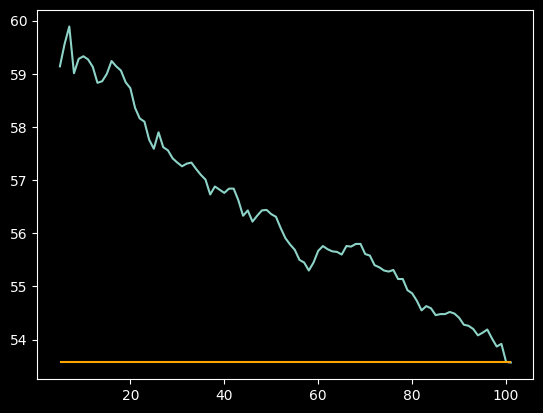

In [12]:
plt.plot(pct_range, results)
plt.hlines(bench_winrate, pct_range[0], pct_range[-1], colors = 'orange')

plt.show()

In [13]:
print(f'Max System Winrate: {max(results)}, at {pct_range[results.index((max(results)))]}')
print(f'Benchmark Winrate: {bench_winrate}')

Max System Winrate: 59.89, at 7
Benchmark Winrate: 53.57
